## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Calibrate camera using chessboard images

In [2]:
import numpy as np
import cv2
import glob
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

def find_chessboard_corners(images, save_image=False):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    #images = glob.glob('../camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            if (save_image == True):
                cv2.imwrite('output_images/camera_cal/'+fname.split('/')[1], img)

    return objpoints, imgpoints

objpoints, imgpoints = find_chessboard_corners(glob.glob('camera_cal/calibration*.jpg'), True)
print("Found Corners")

Found Corners


## Correct distortion

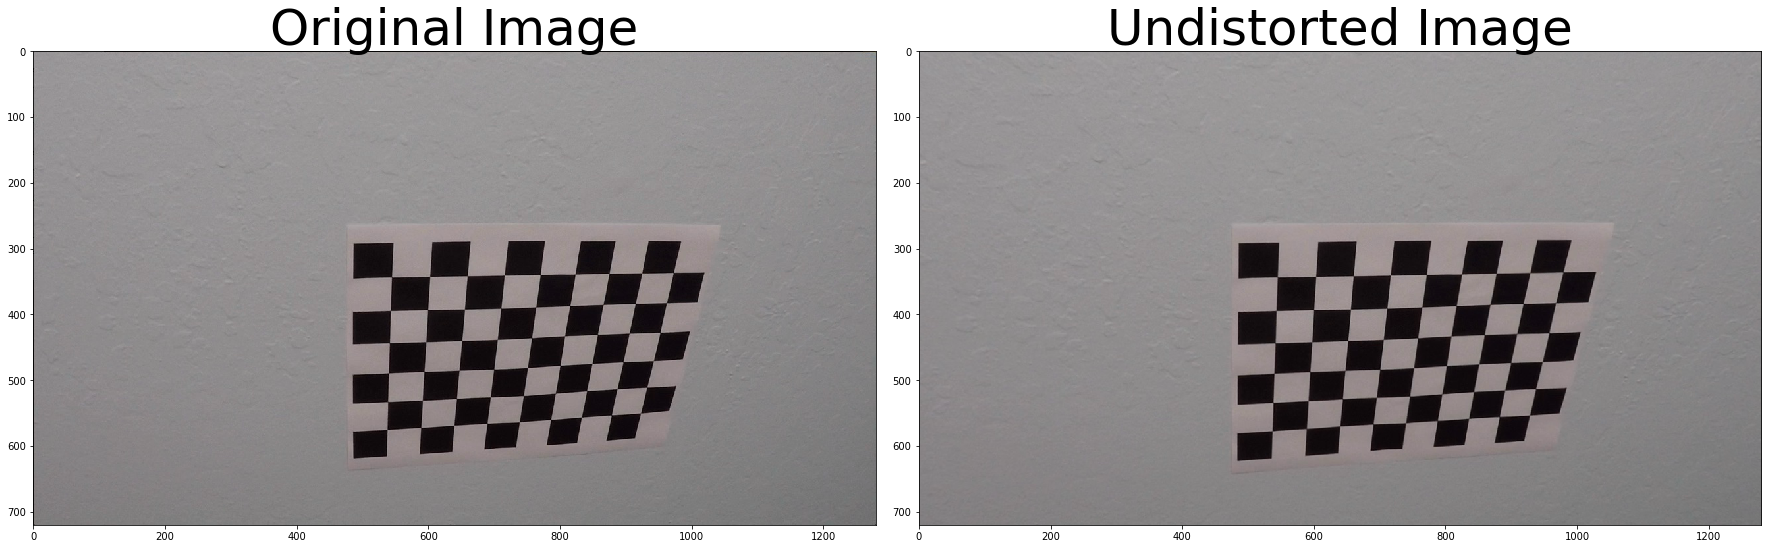

In [3]:
cal_img = cv2.imread('camera_cal/calibration10.jpg')

def calibrate(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (img.shape[1],img.shape[0]), None, None)
    return (mtx, dist)

mtx, dist = calibrate(cal_img, objpoints, imgpoints)

def undistort(img, Mtx=mtx, Dist=dist):
    undist = cv2.undistort(img, Mtx, Dist, None, Mtx)
    return undist

undistorted_cal_img = undistort(cal_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cal_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted_cal_img)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


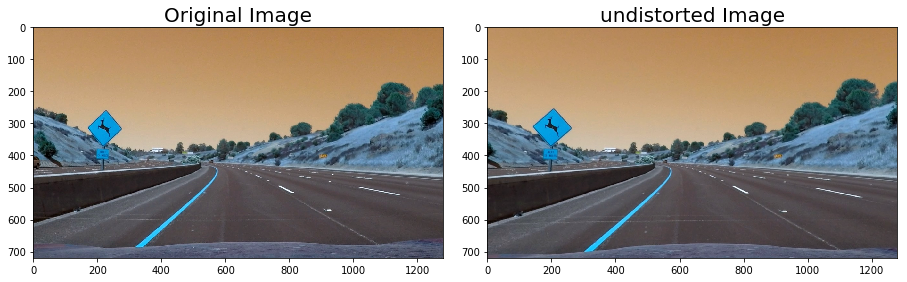

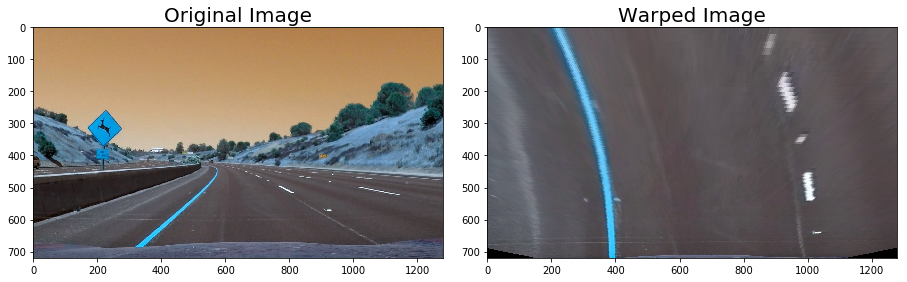

In [16]:
org_img = cv2.imread('test_images/test2.jpg')
img = np.copy(org_img)
h = img.shape[0] # 720
w = img.shape[1] # 1280
src = np.float32([[220,700],[595,450],[685,450],[1070,700]])
dst = np.float32([[320,720],[320,-100],[960,-100],[960,720]])
    
def warp_perspective(img):
    h,w = img.shape[:2]
    warped = np.copy(img) 
    offset = 100
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_NEAREST)
    return warped, M

undistorted = undistort(img)
top_down, _ = warp_perspective(undistorted)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(top_down)
ax2.set_title('Warped Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

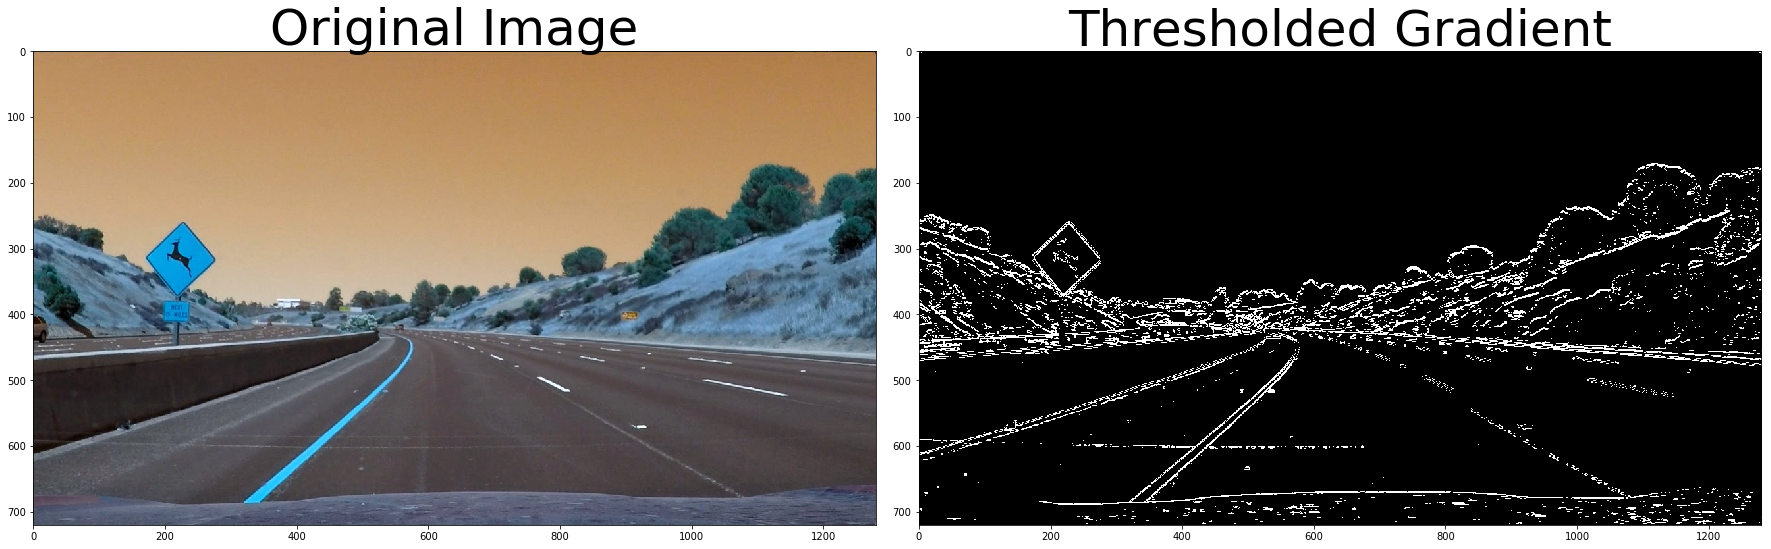

In [5]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_threshold(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

image=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
ksize = 3
gradx = abs_sobel_thresh(image, orient='x', thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', thresh=(20, 100))
mag_binary = mag_threshold(image, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, np.pi/2))
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(org_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

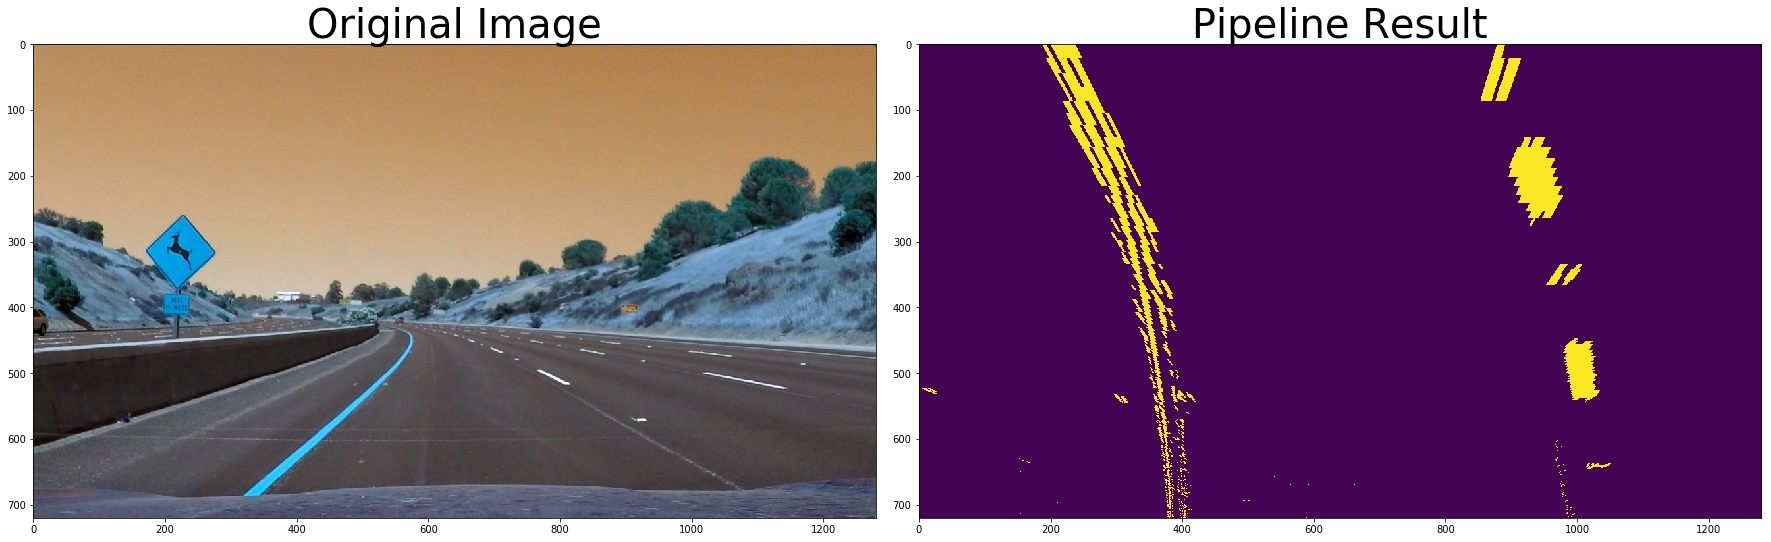

In [6]:
def color_gradient(image):
    # Choose a Sobel kernel size
    ksize = 5 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    red_channel = image[:, :, 0]
    red_equalized = cv2.equalizeHist(red_channel)
    red_binary = np.zeros_like(red_equalized)
    red_binary[(red_equalized > 250) & (red_equalized <= 255)] = 1
    gradx = abs_sobel_thresh(red_channel, orient='x', sobel_kernel=ksize, thresh=(30, 255))
    
    combined_binary = np.zeros_like(red_channel)
    combined_binary[(red_binary == 1) | (gradx == 1)] = 1
    return combined_binary

grad_img = color_gradient(undistorted)
warped_grad_img, _ = warp_perspective(grad_img)


# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(org_img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(warped_grad_img)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

(720, 0)

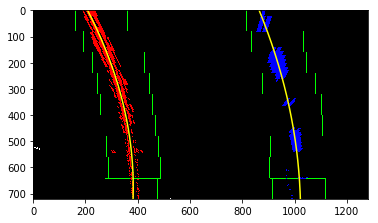

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def find_lanes(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    hist_h = int(binary_warped.shape[0]/2)
    histogram = np.sum(binary_warped[hist_h:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    return (leftx, lefty, rightx, righty, out_img)

def find_lanes_fast(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) 
                      & 
                      (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) 
                       & 
                       (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    return (leftx, lefty, rightx, righty) 

leftx, lefty, rightx, righty, out_img = find_lanes(warped_grad_img)

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [9]:
# Define conversions in x and y from pixels space to meters
# The lane is about 30 meters long and 3.7 meters wide
print(img.shape)
ym_per_pix = 30/h # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
y_eval = np.max(ploty)

def find_curvature_in_m(x, y, xmpp=xm_per_pix, ympp=ym_per_pix, ye=y_eval):
    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y*ympp, x*xmpp, 2)
    # Calculate the new radii of curvature
    curverad = ((1 + (2*fit_cr[0]*ye*ympp + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

def find_offset_in_px(fit):
    offset = -w/2+fit[0]*h**2 + fit[1]*h + fit[2]
    return offset

def find_offset_in_m(fit):
    return find_offset_in_px(fit) * xm_per_pix

def find_curvature_and_offset(leftx, lefty, rightx, righty, debug=False):
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_curverad = find_curvature_in_m(leftx, lefty)
    right_curverad = find_curvature_in_m(rightx, righty)
    curverad = (right_curverad+left_curverad)/2
    
    left_offset = find_offset_in_m(left_fit)
    right_offset = find_offset_in_m(right_fit)
    offset = (left_offset+right_offset)/2                                                          
    leftright = "left" if offset>0 else "right"
    
    if debug == True:
        print("Curvatures: ", left_curverad, 'm', right_curverad, 'm')
        # Example values: 632.1 m    626.2 m
        print("Offsets: ",left_offset, 'm', right_offset, 'm')
        # negative means right
        
    return curverad, abs(offset), leftright

curverad, offset, leftright = find_curvature_and_offset(leftx, lefty, rightx, righty, debug=True)

(720, 1280, 3)
Curvatures:  429.468782769 m 623.855582913 m
Offsets:  -1.36269116265 m 2.01823614132 m


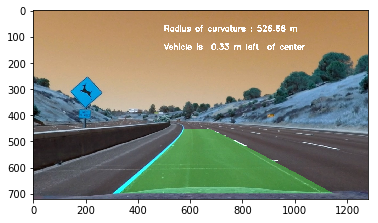

In [10]:
def unwarp(img, undistorted, left_fit, right_fit, Ploty=ploty):
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, Ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, Ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    Minv = cv2.getPerspectiveTransform(dst, src)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w,h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    return result

result = unwarp(warped_grad_img, undistorted, np.polyfit(lefty, leftx, 2), np.polyfit(righty, rightx, 2))
#leftright = "left" if offset>0 else "right"
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(result,'Radius of curvature : {:5.2f} m'.format(curverad),(500, 80),font , 1,(255,255,255),3)
cv2.putText(result,'Vehicle is {:5.2f} m {:5} of center'.format(offset, leftright),(500, 150),font , 1,(255,255,255),3)

plt.imshow(result)

In [12]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]

In [13]:
left = Line()
right = Line()
    
def process_image(image):
    undistorted = undistort(image)
    grad_img = color_gradient(undistorted)
    warped_grad_img, _ = warp_perspective(grad_img)
    left_fit = None
    right_fit = None
    if (left.detected):
        leftx, lefty, rightx, righty = find_lanes_fast(warped_grad_img, left.current_fit, right.current_fit)
    else :
        leftx, lefty, rightx, righty, out_img = find_lanes(warped_grad_img)
        left.detected = True
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    left.current_fit = left_fit
    right.current_fit = right_fit

    curverad, offset, leftright = find_curvature_and_offset(leftx, lefty, rightx, righty)
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    left.current_fit = left_fit
    right.current_fit = right_fit

    unwarped_img = unwarp(warped_grad_img, undistorted, left_fit, right_fit)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(unwarped_img,'Radius of curvature : {:5.2f} m'.format(curverad),(500, 80),font , 1,(255,255,255),3)
    cv2.putText(unwarped_img,'Vehicle is {:5.2f} m {:5} of center'.format(offset, leftright),(500, 150),font , 1,(255,255,255),3)

    if len(unwarped_img.shape) == 2:
        return cv2.cvtColor(np.float32(unwarped_img), cv2.COLOR_GRAY2RGB)
    else:
        return unwarped_img

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'output_video/project_video.mp4'
clip = VideoFileClip("project_video.mp4")
clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_video/project_video.mp4
[MoviePy] Writing video output_video/project_video.mp4


100%|█████████▉| 1260/1261 [02:47<00:00,  4.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/project_video.mp4 

CPU times: user 3min 52s, sys: 2.88 s, total: 3min 55s
Wall time: 2min 49s
